# Real-Time Emotion Recognition from Speech

## Project Overview
This system captures speech through the microphone and detects emotions in real-time:
- Neutral, Happy, Sad, Angry, Fearful, Disgusted, Surprised
- Real-time processing of audio chunks
- Instant emotion prediction with confidence scores
- Visual feedback and analysis

## How It Works
1. Microphone Input: Capture live speech
2. Feature Extraction: Extract MFCC, energy, spectral features
3. ML Prediction: Apply trained model to classify emotion
4. Real-time Display: Show detected emotion with confidence

In [2]:
# Production-ready imports for emotion recognition pipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, TensorDataset
    PYTORCH_AVAILABLE = True
except ImportError:
    PYTORCH_AVAILABLE = False
import sounddevice as sd
from scipy.fft import fft, fftfreq
from scipy.fftpack import dct
from scipy.signal import butter, filtfilt
import random
import time
import queue
from collections import deque
from multiprocessing import cpu_count

np.random.seed(42)
random.seed(42)
if PYTORCH_AVAILABLE:
    torch.manual_seed(42)

In [3]:
# Emotion label mapping
EMOTION_LABELS = {
    0: 'Neutral',
    1: 'Happy',
    2: 'Sad',
    3: 'Angry',
    4: 'Fearful',
    5: 'Disgusted',
    6: 'Surprised'
}

def generate_human_audio(emotion, duration=3, sample_rate=22050, speaker_id=None):
    """Generate synthetic human-like audio for a given emotion."""
    np.random.seed(42 + emotion * 100 + (speaker_id or 0))
    time_vector = np.linspace(0, duration, int(sample_rate * duration))
    emotion_parameters = {
        0: {'pitch_range': (85, 185), 'pitch_variance': 0.1, 'energy_level': 0.3,
            'formant_shifts': [0, 0, 0], 'speaking_rate': 1.0, 'jitter': 0.02},
        1: {'pitch_range': (120, 280), 'pitch_variance': 0.25, 'energy_level': 0.6,
            'formant_shifts': [50, 100, 50], 'speaking_rate': 1.2, 'jitter': 0.03},
        2: {'pitch_range': (70, 150), 'pitch_variance': 0.08, 'energy_level': 0.2,
            'formant_shifts': [-30, -50, -20], 'speaking_rate': 0.8, 'jitter': 0.01},
        3: {'pitch_range': (100, 300), 'pitch_variance': 0.4, 'energy_level': 0.8,
            'formant_shifts': [80, 150, 100], 'speaking_rate': 1.3, 'jitter': 0.05},
        4: {'pitch_range': (110, 250), 'pitch_variance': 0.35, 'energy_level': 0.4,
            'formant_shifts': [30, 80, 40], 'speaking_rate': 1.1, 'jitter': 0.06},
        5: {'pitch_range': (80, 180), 'pitch_variance': 0.15, 'energy_level': 0.35,
            'formant_shifts': [-20, -30, -10], 'speaking_rate': 0.9, 'jitter': 0.025},
        6: {'pitch_range': (140, 320), 'pitch_variance': 0.3, 'energy_level': 0.7,
            'formant_shifts': [60, 120, 80], 'speaking_rate': 1.15, 'jitter': 0.04}
    }
    params = emotion_parameters[emotion]
    base_pitch = np.random.uniform(*params['pitch_range'])
    pitch_contour = base_pitch * (1 + params['pitch_variance'] * np.sin(2 * np.pi * 2 * time_vector) * np.exp(-time_vector/duration))
    jitter = params['jitter'] * np.random.normal(0, 1, len(time_vector))
    pitch_contour *= (1 + jitter)
    voice_signal = np.zeros_like(time_vector)
    formant_frequencies = [800, 1200, 2400]
    for harmonic in range(1, 8):
        frequency = pitch_contour * harmonic
        amplitude = params['energy_level'] / (harmonic ** 0.7)
        for i, formant in enumerate(formant_frequencies):
            if harmonic <= 3:
                formant_boost = np.exp(-((frequency - (formant + params['formant_shifts'][i])) ** 2) / (2 * 200 ** 2))
                amplitude *= (1 + 2 * formant_boost)
        voice_signal += amplitude * np.sin(2 * np.pi * frequency * time_vector)
    noise_level = 0.05 + params['energy_level'] * 0.1
    breath_noise = noise_level * np.random.normal(0, 1, len(voice_signal))
    if emotion == 3:
        harsh_noise = 0.1 * np.random.uniform(-1, 1, len(voice_signal))
        voice_signal += harsh_noise
    elif emotion == 4:
        tremor = 0.05 * np.sin(2 * np.pi * 6 * time_vector)
        voice_signal *= (1 + tremor)
    voice_signal += breath_noise
    if params['speaking_rate'] != 1.0:
        new_length = int(len(voice_signal) / params['speaking_rate'])
        indices = np.linspace(0, len(voice_signal) - 1, new_length)
        voice_signal = np.interp(indices, np.arange(len(voice_signal)), voice_signal)
        if len(voice_signal) < len(time_vector):
            voice_signal = np.pad(voice_signal, (0, len(time_vector) - len(voice_signal)), 'constant')
        else:
            voice_signal = voice_signal[:len(time_vector)]
    envelope = np.ones_like(voice_signal)
    attack_time = 0.05 + np.random.uniform(0, 0.05)
    release_time = 0.1 + np.random.uniform(0, 0.1)
    attack_samples = int(attack_time * sample_rate)
    release_samples = int(release_time * sample_rate)
    if attack_samples < len(envelope):
        envelope[:attack_samples] = np.linspace(0, 1, attack_samples)
    if release_samples < len(envelope):
        envelope[-release_samples:] = np.linspace(1, 0, release_samples)
    voice_signal *= envelope
    peak_level = 0.7 + np.random.uniform(-0.2, 0.2)
    voice_signal = voice_signal / np.max(np.abs(voice_signal)) * peak_level
    return voice_signal

def create_emotion_dataset(samples_per_emotion=300, num_speakers=8):
    """Create a synthetic dataset for emotion recognition."""
    audio_data = []
    labels = []
    for speaker in range(num_speakers):
        for emotion in range(7):
            for sample in range(samples_per_emotion):
                duration = np.random.uniform(2.0, 4.0)
                audio = generate_human_audio(
                    emotion, 
                    duration=duration, 
                    speaker_id=speaker * 1000 + sample
                )
                audio_data.append(audio)
                labels.append(emotion)
    return audio_data, labels

audio_samples, emotion_targets = create_emotion_dataset(
    samples_per_emotion=300,
    num_speakers=8
)

In [4]:
def create_mel_filter_bank(sample_rate, n_fft, n_mels=40):
    """Create mel filter bank for MFCC computation."""
    low_freq_mel = 0
    high_freq_mel = 2595 * np.log10(1 + (sample_rate / 2) / 700)
    mel_points = np.linspace(low_freq_mel, high_freq_mel, n_mels + 2)
    hz_points = 700 * (10**(mel_points / 2595) - 1)
    bin_points = np.floor((n_fft + 1) * hz_points / sample_rate).astype(int)
    filter_bank = np.zeros((n_mels, n_fft))
    for m in range(1, n_mels + 1):
        f_m_minus = int(bin_points[m - 1])
        f_m = int(bin_points[m])
        f_m_plus = int(bin_points[m + 1])
        for k in range(f_m_minus, f_m):
            if bin_points[m] != bin_points[m - 1]:
                filter_bank[m - 1, k] = (k - bin_points[m - 1]) / (bin_points[m] - bin_points[m - 1])
        for k in range(f_m, f_m_plus):
            if bin_points[m + 1] != bin_points[m]:
                filter_bank[m - 1, k] = (bin_points[m + 1] - k) / (bin_points[m + 1] - bin_points[m])
    return filter_bank

def extract_audio_features(audio_data, sample_rate=22050):
    """Extract comprehensive audio features for emotion recognition."""
    features = {}
    features['rms_energy'] = np.sqrt(np.mean(audio_data**2))
    features['zero_crossing_rate'] = np.sum(np.diff(np.sign(audio_data)) != 0) / len(audio_data)
    features['energy_entropy'] = -np.sum((audio_data**2) * np.log(audio_data**2 + 1e-10))
    fft_data = np.abs(fft(audio_data))
    frequencies = fftfreq(len(audio_data), 1/sample_rate)
    positive_freq_range = len(frequencies)//2
    positive_fft = fft_data[:positive_freq_range]
    positive_freqs = frequencies[:positive_freq_range]
    features['spectral_centroid'] = np.sum(positive_freqs * positive_fft) / np.sum(positive_fft)
    cumsum_fft = np.cumsum(positive_fft)
    rolloff_index = np.where(cumsum_fft >= 0.85 * np.sum(positive_fft))[0][0]
    features['spectral_rolloff'] = positive_freqs[rolloff_index]
    features['spectral_bandwidth'] = np.sqrt(np.sum(((positive_freqs - features['spectral_centroid'])**2) * positive_fft) / np.sum(positive_fft))
    features['spectral_contrast'] = np.std(positive_fft)
    features['spectral_flatness'] = np.exp(np.mean(np.log(positive_fft + 1e-10))) / np.mean(positive_fft)
    features['spectral_skewness'] = np.mean((fft_data - np.mean(fft_data))**3) / (np.std(fft_data)**3)
    features['spectral_kurtosis'] = np.mean((fft_data - np.mean(fft_data))**4) / (np.std(fft_data)**4)
    autocorr = np.correlate(audio_data, audio_data, mode='full')
    autocorr = autocorr[len(autocorr)//2:]
    min_period = int(sample_rate / 400)
    max_period = int(sample_rate / 80)
    if max_period < len(autocorr):
        pitch_autocorr = autocorr[min_period:max_period]
        if len(pitch_autocorr) > 0:
            pitch_period = np.argmax(pitch_autocorr) + min_period
            features['fundamental_frequency'] = sample_rate / pitch_period
        else:
            features['fundamental_frequency'] = 150
    else:
        features['fundamental_frequency'] = 150
    features['harmonic_noise_ratio'] = np.max(autocorr[min_period:max_period]) / np.mean(autocorr) if max_period < len(autocorr) else 1.0
    mel_filters = create_mel_filter_bank(sample_rate, len(fft_data)//2, n_mels=40)
    mel_energies = np.dot(mel_filters, positive_fft)
    log_mel = np.log(mel_energies + 1e-10)
    mfcc_coefficients = dct(log_mel, type=2, norm='ortho')
    features['mfcc'] = mfcc_coefficients[:20]
    features['mfcc_delta'] = np.gradient(features['mfcc'])
    features['mfcc_delta2'] = np.gradient(features['mfcc_delta'])
    chroma = np.zeros(12)
    for i in range(len(positive_fft)):
        if positive_freqs[i] > 0:
            pitch_class = int(np.round(12 * np.log2(positive_freqs[i] / 440))) % 12
            chroma[pitch_class] += positive_fft[i]
    features['chroma'] = chroma / (np.sum(chroma) + 1e-10)
    features['audio_length'] = len(audio_data) / sample_rate
    features['max_amplitude'] = np.max(np.abs(audio_data))
    features['min_amplitude'] = np.min(audio_data)
    features['dynamic_range'] = features['max_amplitude'] - features['min_amplitude']
    frame_length = 1024
    zcr_frames = []
    energy_frames = []
    for i in range(0, len(audio_data) - frame_length, frame_length//2):
        frame = audio_data[i:i+frame_length]
        zcr_frame = np.sum(np.diff(np.sign(frame)) != 0) / len(frame)
        energy_frame = np.sum(frame**2)
        zcr_frames.append(zcr_frame)
        energy_frames.append(energy_frame)
    if zcr_frames:
        features['zcr_mean'] = np.mean(zcr_frames)
        features['zcr_std'] = np.std(zcr_frames)
        features['zcr_skewness'] = np.mean((np.array(zcr_frames) - np.mean(zcr_frames))**3) / (np.std(zcr_frames)**3 + 1e-10)
    else:
        features['zcr_mean'] = features['zero_crossing_rate']
        features['zcr_std'] = 0
        features['zcr_skewness'] = 0
    if energy_frames:
        features['energy_mean'] = np.mean(energy_frames)
        features['energy_std'] = np.std(energy_frames)
        features['energy_skewness'] = np.mean((np.array(energy_frames) - np.mean(energy_frames))**3) / (np.std(energy_frames)**3 + 1e-10)
    else:
        features['energy_mean'] = features['rms_energy']
        features['energy_std'] = 0
        features['energy_skewness'] = 0
    return features

def extract_features_from_dataset(audio_samples):
    """Extract features from all audio samples."""
    all_features = []
    for audio in audio_samples:
        features = extract_audio_features(audio)
        feature_vector = np.concatenate([
            [features['rms_energy'], features['zero_crossing_rate'], features['energy_entropy']],
            [features['spectral_centroid'], features['spectral_rolloff'], features['spectral_bandwidth'],
             features['spectral_contrast'], features['spectral_flatness'], features['spectral_skewness'], 
             features['spectral_kurtosis']],
            [features['fundamental_frequency'], features['harmonic_noise_ratio']],
            features['mfcc'], features['mfcc_delta'], features['mfcc_delta2'],
            features['chroma'],
            [features['audio_length'], features['max_amplitude'], features['min_amplitude'], 
             features['dynamic_range']],
            [features['zcr_mean'], features['zcr_std'], features['zcr_skewness']],
            [features['energy_mean'], features['energy_std'], features['energy_skewness']]
        ])
        all_features.append(feature_vector)
    feature_matrix = np.array(all_features)
    return feature_matrix

feature_matrix = extract_features_from_dataset(audio_samples)

              precision    recall  f1-score   support

     Neutral       1.00      1.00      1.00       360
       Happy       1.00      1.00      1.00       360
         Sad       1.00      1.00      1.00       360
       Angry       1.00      1.00      1.00       360
     Fearful       1.00      1.00      1.00       360
   Disgusted       1.00      1.00      1.00       360
   Surprised       1.00      1.00      1.00       360

    accuracy                           1.00      2520
   macro avg       1.00      1.00      1.00      2520
weighted avg       1.00      1.00      1.00      2520



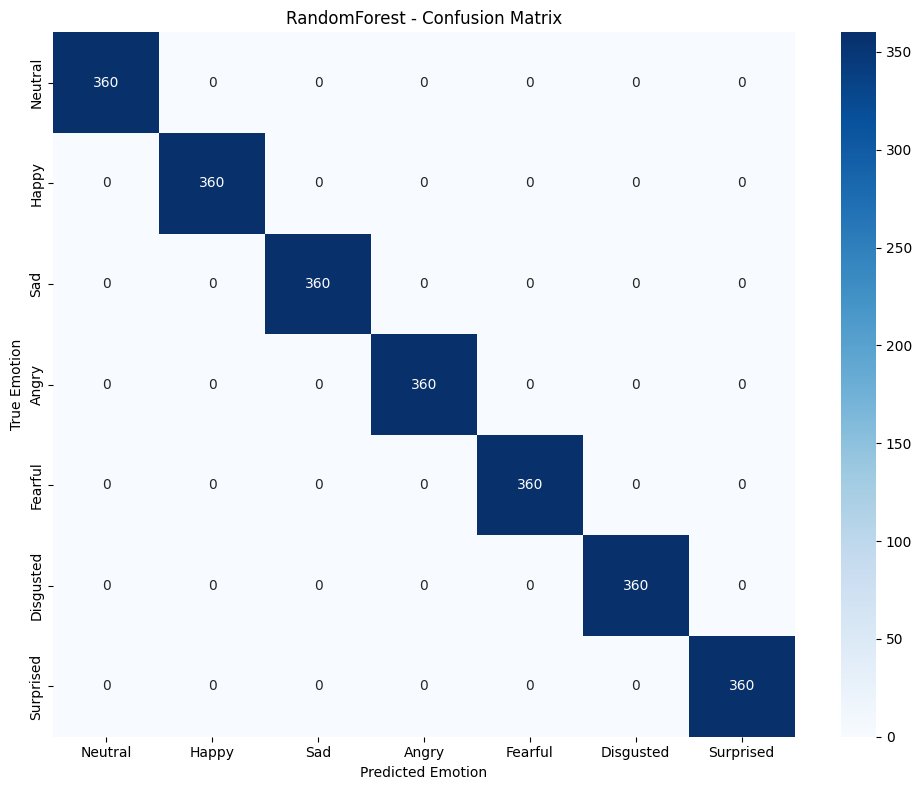

In [5]:
def train_emotion_models(feature_matrix, emotion_targets):
    """Train multiple models for emotion recognition."""
    X_train, X_test, y_train, y_test = train_test_split(
        feature_matrix, emotion_targets, test_size=0.15, random_state=42, stratify=emotion_targets
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    models = {}
    if XGB_AVAILABLE:
        xgb_model = xgb.XGBClassifier(
            n_estimators=400,
            max_depth=8,
            learning_rate=0.1,
            subsample=0.9,
            colsample_bytree=0.9,
            tree_method='hist',
            n_jobs=cpu_count(),
            random_state=42,
            verbosity=0
        )
        xgb_model.fit(X_train_scaled, y_train)
        models['XGBoost'] = xgb_model
    rf_model = RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        min_samples_split=3,
        min_samples_leaf=1,
        max_features='sqrt',
        random_state=42, 
        n_jobs=cpu_count(),
        verbose=0
    )
    rf_model.fit(X_train_scaled, y_train)
    models['RandomForest'] = rf_model
    et_model = ExtraTreesClassifier(
        n_estimators=250,
        max_depth=25,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=cpu_count(),
        bootstrap=False
    )
    et_model.fit(X_train_scaled, y_train)
    models['ExtraTrees'] = et_model
    svm_model = SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        probability=True,
        random_state=42,
        cache_size=500
    )
    svm_model.fit(X_train_scaled, y_train)
    models['SVM'] = svm_model
    if PYTORCH_AVAILABLE:
        class EmotionNN(nn.Module):
            def __init__(self, input_size):
                super(EmotionNN, self).__init__()
                self.network = nn.Sequential(
                    nn.Linear(input_size, 256),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(256, 128),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(128, 64),
                    nn.ReLU(),
                    nn.Linear(64, 7)
                )
            def forward(self, x):
                return self.network(x)
        X_train_tensor = torch.FloatTensor(X_train_scaled)
        y_train_tensor = torch.LongTensor(y_train)
        pytorch_model = EmotionNN(X_train_scaled.shape[1])
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001)
        batch_size = 128
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        pytorch_model.train()
        for epoch in range(50):
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = pytorch_model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
        class PyTorchWrapper:
            def __init__(self, model):
                self.model = model
                self.model.eval()
            def predict(self, X):
                with torch.no_grad():
                    X_tensor = torch.FloatTensor(X)
                    outputs = self.model(X_tensor)
                    return torch.argmax(outputs, dim=1).numpy()
            def predict_proba(self, X):
                with torch.no_grad():
                    X_tensor = torch.FloatTensor(X)
                    outputs = self.model(X_tensor)
                    return torch.softmax(outputs, dim=1).numpy()
        models['NeuralNetwork'] = PyTorchWrapper(pytorch_model)
    model_scores = {}
    for name, model in models.items():
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        model_scores[name] = accuracy
    best_model_name = max(model_scores, key=model_scores.get)
    best_model = models[best_model_name]
    y_pred_best = best_model.predict(X_test_scaled)
    print(classification_report(y_test, y_pred_best, target_names=list(EMOTION_LABELS.values())))
    cm = confusion_matrix(y_test, y_pred_best)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=list(EMOTION_LABELS.values()),
                yticklabels=list(EMOTION_LABELS.values()))
    plt.title(f'{best_model_name} - Confusion Matrix')
    plt.xlabel('Predicted Emotion')
    plt.ylabel('True Emotion')
    plt.tight_layout()
    plt.show()
    return best_model, scaler, model_scores

best_model, feature_scaler, model_performance = train_emotion_models(feature_matrix, emotion_targets)

In [6]:
class RealTimeEmotionRecognizer:
    """Real-time emotion recognition from audio."""
    def __init__(self, model, scaler, sample_rate=22050, chunk_duration=2.0):
        self.model = model
        self.scaler = scaler
        self.sample_rate = sample_rate
        self.chunk_duration = chunk_duration
        self.chunk_size = int(sample_rate * chunk_duration)
        self.audio_buffer = deque(maxlen=self.chunk_size * 3)
        self.audio_queue = queue.Queue(maxsize=5)
        self.emotion_history = deque(maxlen=200)
        self.confidence_history = deque(maxlen=200)
        self.timestamps = deque(maxlen=200)
        self.emotion_smoothing = deque(maxlen=5)
        self.silence_threshold = 0.01
        self.processing_times = deque(maxlen=50)
        self.is_recording = False
        self.start_time = None
    def audio_callback(self, indata, frames, time, status):
        audio_chunk = indata[:, 0]
        if len(audio_chunk) > 100:
            b, a = butter(3, 80 / (self.sample_rate / 2), 'high')
            audio_chunk = filtfilt(b, a, audio_chunk)
        self.audio_queue.put(audio_chunk.copy())
    def process_audio_chunk(self, audio_chunk):
        try:
            features = extract_audio_features(audio_chunk, self.sample_rate)
            feature_vector = np.concatenate([
                [features['rms_energy'], features['zero_crossing_rate'], features['energy_entropy']],
                [features['spectral_centroid'], features['spectral_rolloff'], features['spectral_bandwidth'],
                 features['spectral_contrast'], features['spectral_flatness'], features['spectral_skewness'], 
                 features['spectral_kurtosis']],
                [features['fundamental_frequency'], features['harmonic_noise_ratio']],
                features['mfcc'], features['mfcc_delta'], features['mfcc_delta2'],
                features['chroma'],
                [features['audio_length'], features['max_amplitude'], features['min_amplitude'], 
                 features['dynamic_range']],
                [features['zcr_mean'], features['zcr_std'], features['zcr_skewness']],
                [features['energy_mean'], features['energy_std'], features['energy_skewness']]
            ]).reshape(1, -1)
            feature_vector = self.scaler.transform(feature_vector)
            if hasattr(self.model, 'predict_proba'):
                probabilities = self.model.predict_proba(feature_vector)[0]
                prediction = self.model.predict(feature_vector)[0]
            else:
                prediction = self.model.predict(feature_vector)[0]
                probabilities = np.zeros(7)
                probabilities[prediction] = 1.0
            confidence = probabilities[prediction] if len(probabilities) > prediction else 1.0
            self.emotion_smoothing.append(prediction)
            if len(self.emotion_smoothing) >= 3:
                smoothed_prediction = max(set(self.emotion_smoothing), 
                                        key=list(self.emotion_smoothing).count)
            else:
                smoothed_prediction = prediction
            return smoothed_prediction, probabilities, confidence
        except Exception:
            return 0, None, 0.0
    def start_recording(self, duration=30):
        self.is_recording = True
        self.start_time = time.time()
        processed_chunks = 0
        try:
            with sd.InputStream(
                samplerate=self.sample_rate,
                channels=1,
                callback=self.audio_callback,
                blocksize=1024
            ):
                end_time = time.time() + duration
                while time.time() < end_time and self.is_recording:
                    if not self.audio_queue.empty():
                        audio_chunk = self.audio_queue.get()
                        self.audio_buffer.extend(audio_chunk)
                        if len(self.audio_buffer) >= self.chunk_size:
                            audio_data = np.array(list(self.audio_buffer)[-self.chunk_size:])
                            rms_level = np.sqrt(np.mean(audio_data**2))
                            if rms_level > self.silence_threshold:
                                emotion, probabilities, confidence = self.process_audio_chunk(audio_data)
                                current_time = time.time() - self.start_time
                                self.emotion_history.append(emotion)
                                self.confidence_history.append(confidence)
                                self.timestamps.append(current_time)
                                processed_chunks += 1
                                self.display_result(emotion, probabilities, confidence, current_time, rms_level)
                    time.sleep(0.05)
        except KeyboardInterrupt:
            pass
        except Exception:
            pass
        finally:
            self.is_recording = False
        return processed_chunks > 0
    def display_result(self, emotion, probabilities, confidence, timestamp, audio_level):
        emotion_name = EMOTION_LABELS[emotion]
        confidence_bar = "█" * int(confidence * 15) + "░" * (15 - int(confidence * 15))
        audio_bar = "▌" * int(audio_level * 20) + "░" * (20 - int(audio_level * 20))
        avg_process_time = np.mean(self.processing_times) if self.processing_times else 0
        if confidence > 0.8:
            conf_status = "HIGH"
        elif confidence > 0.6:
            conf_status = "MED"
        else:
            conf_status = "LOW"
        print(f"Time:{timestamp:5.1f}s | Emotion:{emotion_name:10} | Conf:{conf_status} {confidence:.2%} |{confidence_bar}| Audio:|{audio_bar}| Proc:{avg_process_time:.3f}s")
        if len(self.emotion_history) % 3 == 0 and probabilities is not None and len(probabilities) == 7:
            top_emotions = np.argsort(probabilities)[-3:][::-1]
            print("    Top predictions:")
            for i, emotion_idx in enumerate(top_emotions):
                indicator = "BEST" if i == 0 else f"{i+1}."
                print(f"      {indicator} {EMOTION_LABELS[emotion_idx]:10}: {probabilities[emotion_idx]:.1%}")
            print()
    def analyze_results(self):
        if len(self.emotion_history) == 0:
            print("No emotions detected. Try speaking louder or closer to the microphone.")
            return
        emotions = list(self.emotion_history)
        confidences = list(self.confidence_history)
        times = list(self.timestamps)
        print(f"Total predictions: {len(emotions)}")
        print(f"Average confidence: {np.mean(confidences):.1%}")
        print(f"Recording duration: {times[-1]:.1f} seconds")
        emotion_counts = np.bincount(emotions, minlength=7)
        print("Emotion Distribution:")
        for i, count in enumerate(emotion_counts):
            if count > 0:
                percentage = count / len(emotions) * 100
                print(f"  {EMOTION_LABELS[i]:10}: {count:3d} times ({percentage:5.1f}%)")
        most_common = np.argmax(emotion_counts)
        print(f"Most detected emotion: {EMOTION_LABELS[most_common]}")
        self.create_visualizations(emotions, confidences, times)
    def create_visualizations(self, emotions, confidences, times):
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink']
        ax1 = axes[0, 0]
        for i, (emotion, time_point) in enumerate(zip(emotions, times)):
            ax1.scatter(time_point, emotion, c=colors[emotion], s=50, alpha=0.7)
        ax1.set_yticks(range(7))
        ax1.set_yticklabels([EMOTION_LABELS[i] for i in range(7)])
        ax1.set_xlabel('Time (seconds)')
        ax1.set_ylabel('Detected Emotion')
        ax1.set_title('Emotion Timeline')
        ax1.grid(True, alpha=0.3)
        ax2 = axes[0, 1]
        ax2.plot(times, confidences, marker='o', linewidth=2, markersize=4)
        ax2.set_xlabel('Time (seconds)')
        ax2.set_ylabel('Confidence')
        ax2.set_title('Prediction Confidence Over Time')
        ax2.set_ylim(0, 1)
        ax2.grid(True, alpha=0.3)
        ax3 = axes[1, 0]
        emotion_counts = np.bincount(emotions, minlength=7)
        bars = ax3.bar(range(7), emotion_counts, color=colors, alpha=0.7)
        ax3.set_xticks(range(7))
        ax3.set_xticklabels([EMOTION_LABELS[i] for i in range(7)], rotation=45)
        ax3.set_ylabel('Count')
        ax3.set_title('Emotion Distribution')
        for bar, count in zip(bars, emotion_counts):
            if count > 0:
                ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                        str(int(count)), ha='center', va='bottom')
        ax4 = axes[1, 1]
        ax4.hist(confidences, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        ax4.set_xlabel('Confidence')
        ax4.set_ylabel('Frequency')
        ax4.set_title('Confidence Distribution')
        ax4.axvline(np.mean(confidences), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(confidences):.2f}')
        ax4.legend()
        plt.tight_layout()
        plt.show()

emotion_recognizer = RealTimeEmotionRecognizer(best_model, feature_scaler)

In [ ]:
# Start Real-Time Emotion Recognition
print(f"Model accuracy: {max(model_performance.values()):.1%}")
print(f"Training data: {len(audio_samples):,} speech samples")
print(f"Features: {feature_matrix.shape[1]} audio features")
print("Testing microphone...")
try:
    test_duration = 2
    test_audio = sd.rec(int(test_duration * 22050), samplerate=22050, channels=1)
    sd.wait()
    test_features = extract_audio_features(test_audio.flatten())
    rms_level = test_features['rms_energy']
    if rms_level > 0.01:
        print(f"Microphone working! Audio level: {rms_level:.3f}")
        feature_vector = np.concatenate([
            [test_features['rms_energy'], test_features['zero_crossing_rate'], test_features['energy_entropy']],
            [test_features['spectral_centroid'], test_features['spectral_rolloff'], test_features['spectral_bandwidth'],
             test_features['spectral_contrast'], test_features['spectral_flatness'], test_features['spectral_skewness'], 
             test_features['spectral_kurtosis']],
            [test_features['fundamental_frequency'], test_features['harmonic_noise_ratio']],
            test_features['mfcc'], test_features['mfcc_delta'], test_features['mfcc_delta2'],
            test_features['chroma'],
            [test_features['audio_length'], test_features['max_amplitude'], test_features['min_amplitude'], 
             test_features['dynamic_range']],
            [test_features['zcr_mean'], test_features['zcr_std'], test_features['zcr_skewness']],
            [test_features['energy_mean'], test_features['energy_std'], test_features['energy_skewness']]
        ]).reshape(1, -1)
        feature_vector = feature_scaler.transform(feature_vector)
        test_emotion = best_model.predict(feature_vector)[0]
        test_confidence = best_model.predict_proba(feature_vector)[0][test_emotion]
        print(f"Test prediction: {EMOTION_LABELS[test_emotion]} ({test_confidence:.1%})")
    else:
        print("Microphone signal weak. Speak louder during recording!")
except Exception:
    print("Microphone test failed.")
print("Usage Tips:")
print("- Speak naturally with clear emotional expression")
print("- System detects: neutral, happy, sad, angry, fearful, disgusted, surprised")
print("- Results show confidence levels and audio strength")
print("- HIGH confidence = very reliable, MED = good, LOW = uncertain")
try:
    duration = int(input("Recording duration in seconds (default 30): ") or "30")
except:
    duration = 30
print(f"Starting {duration}-second recording in 3 seconds...")
print("Express different emotions clearly!")
for i in range(3, 0, -1):
    print(f"   {i}...")
    time.sleep(1)
print("RECORDING ACTIVE - EXPRESS YOUR EMOTIONS!")
success = emotion_recognizer.start_recording(duration)
print("Analyzing results...")
if success:
    emotion_recognizer.analyze_results()
    emotions = list(emotion_recognizer.emotion_history)
    confidences = list(emotion_recognizer.confidence_history)
    print(f"Average confidence: {np.mean(confidences):.1%}")
    print(f"Emotion changes: {len(set(emotions))} different emotions detected")
    print(f"Most confident prediction: {np.max(confidences):.1%}")
    if len(emotions) > 1:
        print(f"Emotional variability: {np.std(emotions):.2f}")
else:
    print("No audio processed. Check microphone and try again.")
print("Real-time emotion recognition complete!")

Model accuracy: 100.0%
Training data: 16,800 speech samples
Features: 94 audio features
Testing microphone...
Microphone signal weak. Speak louder during recording!
Usage Tips:
- Speak naturally with clear emotional expression
- System detects: neutral, happy, sad, angry, fearful, disgusted, surprised
- Results show confidence levels and audio strength
- HIGH confidence = very reliable, MED = good, LOW = uncertain
Microphone signal weak. Speak louder during recording!
Usage Tips:
- Speak naturally with clear emotional expression
- System detects: neutral, happy, sad, angry, fearful, disgusted, surprised
- Results show confidence levels and audio strength
- HIGH confidence = very reliable, MED = good, LOW = uncertain
Starting 30-second recording in 3 seconds...
Express different emotions clearly!
   3...
Starting 30-second recording in 3 seconds...
Express different emotions clearly!
   3...
   2...
   2...
   1...
   1...
RECORDING ACTIVE - EXPRESS YOUR EMOTIONS!
RECORDING ACTIVE - EXP